# Fundamental Law of Memory Recall 



## Load packages

In [1]:
#!sudo apt-get install texlive-full  

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib import cm
import random
import heapq
from collections import Counter
import scipy as sp
import pickle
import os

#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')

## Model explanation

Item representations are chosen as random binary $\{0,1\}$ vectors where each element of the vector chosen to be 1 with small probability $f \ll 1$ independently of other elements.
Overlaps are defined as scalar products between these
representations.

The proposed recall process is based on two principles:

1. memory items are represented in the brain by overlapping random sparse neuronal ensembles in dedicated memory networks;
2. the next item to be recalled is the one with a largest overlap to the current one, excluding the item that was recalled on the previous step.

Pseudocode:
- find the second largest value in the first row of SM
- go to the row corresponding to its column index
- iterate 


## Define the functions

In [3]:
def BuildItems(L, N, f): 
    """
    L = number of items
    N = number of neurons
    f = probability of a neuron to be 1
    """
    #np.random.seed(5) # good example with seed = 5, L = 5, N = 3000, f = 0.1
    return np.random.choice([0, 1], size=(N, L), p=[1-f, f])

def SparseRandomEnsemble(L, N, f):
    items = sp.sparse.random(N, L, density=f).A
    for i in range(N):
        for j in range(L):
            if items[i,j] != 0:
                items[i,j] = 1
    return items

def SimilarityMatrix(items):
    sim = np.dot(items.T, items)
    # change the diagonal elements from 0 to 1 so that it does not interfere when we are
    # searching for the maximum element in a row
    np.fill_diagonal(sim, 0)
    return sim 

def PlotSM(sim, L):
    sns.set_context({"figure.figsize": (12, 12)})
    sns.set_style("white")
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('Blues', 20)
    cmap.set_bad('w') # default value is 'k'
    ax1.imshow(sim, cmap=cmap)
    #plt.ylabel("Cluster", size = L)
    #plt.xlabel("Cluster", size = L)
    sns.despine()
    plt.colorbar(ax1.matshow(sim, cmap=cmap), shrink=.75)
    ax1.xaxis.set_label_position('bottom')
    ax1.xaxis.set_ticks_position('bottom')
    plt.xticks(range(0,L,1), size = L)
    plt.yticks(range(0,L,1), size = L)
    #plt.savefig('similarity_matrix.pdf', dpi=220, bbox_inches='tight')

def memory_recall_process(L, N, f, vb='off'):
    items = BuildItems(L, N, f)
    sim = SimilarityMatrix(items)
    if vb == 's': 
        print(sim)
    recall_list = []
    recall_list.append(0)
    recall_list.append(np.where(sim[0, ] == sim[0, ].max())[0][0])
    for i in range(1, L**2): 
        if vb == 'sr':
            print("Recall list =", recall_list)
        recall_list.append(np.where(sim[recall_list[i], ] == sim[recall_list[i], ].max())[0][0])
        if (recall_list[i+1] == recall_list[i-1]):
            sl = heapq.nlargest(2, sim[recall_list[i], ])
            if sl[0] == sl[1]:
                recall_list[i+1] = np.where(sim[recall_list[i], ] == sl[1])[0][1]
                if (recall_list[i+1] == recall_list[i-1]):
                    recall_list[i+1] = np.where(sim[recall_list[i], ] == sl[1])[0][0]
            else:
                recall_list[i+1] = np.where(sim[recall_list[i], ] == sl[1])[0][0]
        ############################################################################################
        # Stopping condition:
        # if two previously visited items are retrieved in the same order then stop.
        for j in range(len(recall_list)-1):
            for k in range(len(recall_list)-1):
                if recall_list[j:j+2] == recall_list[k+j+1:k+j+3]:
                    break
            else:
                continue
            break 
        else:
            continue
        break 
        ############################################################################################
    R = len(set(recall_list))
    return R

def TheoreticalScaling(L):
    return np.sqrt(1.5*np.pi*float(L))

## Run a small test

In [4]:
r = memory_recall_process(10, 3000, 0.1, vb='s')
r

[[ 0 33 38 48 25 27 29 37 38 33]
 [33  0 28 23 25 32 41 27 38 26]
 [38 28  0 25 29 35 31 29 32 26]
 [48 23 25  0 29 27 34 40 31 28]
 [25 25 29 29  0 33 43 35 22 31]
 [27 32 35 27 33  0 27 18 33 28]
 [29 41 31 34 43 27  0 26 33 24]
 [37 27 29 40 35 18 26  0 30 35]
 [38 38 32 31 22 33 33 30  0 30]
 [33 26 26 28 31 28 24 35 30  0]]


3

## Do the actual computation

In [5]:
dirName = 'batch'
if not os.path.exists(dirName):
    os.mkdir(dirName)
    print("Directory", dirName, "created.")
else:    
    print("Directory", dirName, "already exists.")

os.chdir("/content/batch")

N = 20000
f_val = [0.1, 0.05, 0.01]
L_val = [10, 20, 50, 80, 130, 280, 500]

nruns = 100

R_f01_L10 =  []
R_f01_L20 =  []
R_f01_L50 =  [] 
R_f01_L80 =  []
R_f01_L130 = []
R_f01_L280 = []
R_f01_L500 = [] 

R_f005_L10 =  []
R_f005_L20 =  []
R_f005_L50 =  []
R_f005_L80 =  []
R_f005_L130 = []
R_f005_L280 = []
R_f005_L500 = [] 

R_f001_L10 =  []
R_f001_L20 =  []
R_f001_L50 =  []
R_f001_L80 =  []
R_f001_L130 = []
R_f001_L280 = []
R_f001_L500 = []

for run in range(nruns):
    print("run ", run)
    print("f=0.1")
    R_f01_L10 .append(memory_recall_process(L_val[0], N, f_val[0]))
    R_f01_L20 .append(memory_recall_process(L_val[1], N, f_val[0]))
    R_f01_L50 .append(memory_recall_process(L_val[2], N, f_val[0]))
    R_f01_L80 .append(memory_recall_process(L_val[3], N, f_val[0]))
    R_f01_L130.append(memory_recall_process(L_val[4], N, f_val[0]))
    R_f01_L280.append(memory_recall_process(L_val[5], N, f_val[0]))
    R_f01_L500.append(memory_recall_process(L_val[6], N, f_val[0]))
    print("f=0.05")
    R_f005_L10 .append(memory_recall_process(L_val[0], N, f_val[1]))
    R_f005_L20 .append(memory_recall_process(L_val[1], N, f_val[1]))
    R_f005_L50 .append(memory_recall_process(L_val[2], N, f_val[1]))
    R_f005_L80 .append(memory_recall_process(L_val[3], N, f_val[1]))
    R_f005_L130.append(memory_recall_process(L_val[4], N, f_val[1]))
    R_f005_L280.append(memory_recall_process(L_val[5], N, f_val[1]))
    R_f005_L500.append(memory_recall_process(L_val[6], N, f_val[1])) 
    print("f=0.01")
    R_f001_L10 .append(memory_recall_process(L_val[0], N, f_val[2]))
    R_f001_L20 .append(memory_recall_process(L_val[1], N, f_val[2]))
    R_f001_L50 .append(memory_recall_process(L_val[2], N, f_val[2]))
    R_f001_L80 .append(memory_recall_process(L_val[3], N, f_val[2]))
    R_f001_L130.append(memory_recall_process(L_val[4], N, f_val[2]))
    R_f001_L280.append(memory_recall_process(L_val[5], N, f_val[2]))
    R_f001_L500.append(memory_recall_process(L_val[6], N, f_val[2]))
    if run == 0 or run == 4 or run == 25 or run == 50 or run == 75:
        Rlist = [R_f01_L10, R_f01_L20, R_f01_L50, R_f01_L80, R_f01_L130, R_f01_L280, R_f01_L500,
                 R_f005_L10, R_f005_L20, R_f005_L50, R_f005_L80, R_f005_L130, R_f005_L280, R_f005_L500,
                 R_f001_L10, R_f001_L20, R_f001_L50, R_f001_L80, R_f001_L130, R_f001_L280, R_f001_L500]
        Rlist_names = ['R_f01_L10', 'R_f01_L20', 'R_f01_L50', 'R_f01_L80', 'R_f01_L130', 'R_f01_L280', 'R_f01_L500',
                       'R_f005_L10', 'R_f005_L20', 'R_f005_L50', 'R_f005_L80', 'R_f005_L130', 'R_f005_L280', 'R_f005_L500',
                       'R_f001_L10', 'R_f001_L20', 'R_f001_L50', 'R_f001_L80', 'R_f001_L130', 'R_f001_L280', 'R_f001_L500']
        for l in range(len(Rlist)):
            if run == 0:
                with open(Rlist_names[l]+'.pkl', "wb") as f:
                    pickle.dump(Rlist[l], f)
                    f.close()
            else:
                with open(Rlist_names[l]+'.pkl', "rb") as f:
                    loaded_list = pickle.load(f)
                    f.close()
                Rlist[l] = loaded_list+Rlist[l] 
                with open(Rlist_names[l]+'.pkl', 'wb') as f:
                    pickle.dump(Rlist[l], f)
                    f.close()
        print('Saved.')

Directory batch created.
run  0
f=0.1
f=0.05
f=0.01
Saved.
run  1
f=0.1
f=0.05
f=0.01
run  2
f=0.1
f=0.05
f=0.01
run  3
f=0.1
f=0.05
f=0.01
run  4
f=0.1
f=0.05
f=0.01
Saved.
run  5
f=0.1
f=0.05
f=0.01
run  6
f=0.1
f=0.05
f=0.01
run  7
f=0.1
f=0.05
f=0.01
run  8
f=0.1
f=0.05
f=0.01
run  9
f=0.1
f=0.05
f=0.01
run  10
f=0.1
f=0.05
f=0.01
run  11
f=0.1
f=0.05
f=0.01
run  12
f=0.1
f=0.05
f=0.01
run  13
f=0.1
f=0.05
f=0.01
run  14
f=0.1
f=0.05
f=0.01
run  15
f=0.1
f=0.05
f=0.01
run  16
f=0.1
f=0.05
f=0.01
run  17
f=0.1
f=0.05
f=0.01
run  18
f=0.1
f=0.05
f=0.01
run  19
f=0.1
f=0.05
f=0.01
run  20
f=0.1
f=0.05
f=0.01
run  21
f=0.1
f=0.05
f=0.01
run  22
f=0.1
f=0.05
f=0.01
run  23
f=0.1
f=0.05
f=0.01
run  24
f=0.1
f=0.05
f=0.01
run  25
f=0.1
f=0.05
f=0.01
Saved.
run  26
f=0.1
f=0.05
f=0.01
run  27
f=0.1
f=0.05
f=0.01
run  28
f=0.1
f=0.05
f=0.01
run  29
f=0.1
f=0.05
f=0.01
run  30
f=0.1
f=0.05
f=0.01
run  31
f=0.1
f=0.05
f=0.01
run  32
f=0.1
f=0.05
f=0.01
run  33
f=0.1
f=0.05
f=0.01
run  34
f=0.

In [6]:
R_f01  = [R_f01_L10 , R_f01_L20 , R_f01_L50 , R_f01_L80 , R_f01_L130 , R_f01_L280 , R_f01_L500]
R_f005 = [R_f005_L10, R_f005_L20, R_f005_L50, R_f005_L80, R_f005_L130, R_f005_L280, R_f005_L500]
R_f001 = [R_f001_L10, R_f001_L20, R_f001_L50, R_f001_L80, R_f001_L130, R_f001_L280, R_f001_L500]

R_f01_mean  = [np.mean(R_f01_L10), 
               np.mean(R_f01_L20), 
               np.mean(R_f01_L50),
               np.mean(R_f01_L80),
               np.mean(R_f01_L130), 
               np.mean(R_f01_L280), 
               np.mean(R_f01_L500)]

R_f005_mean  = [np.mean(R_f005_L10), 
                np.mean(R_f005_L20), 
                np.mean(R_f005_L50),
                np.mean(R_f005_L80),
                np.mean(R_f005_L130), 
                np.mean(R_f005_L280), 
                np.mean(R_f005_L500)]

R_f001_mean  = [np.mean(R_f001_L10), 
                np.mean(R_f001_L20), 
                np.mean(R_f001_L50),
                np.mean(R_f001_L80),
                np.mean(R_f001_L130), 
                np.mean(R_f001_L280), 
                np.mean(R_f001_L500)]

### Save the results

In [7]:
with open('Rf_01_20000_100runs.pkl', "wb") as f:
    pickle.dump(R_f01, f)
    f.close()
with open('Rf_01_20000_100runs_mean.pkl', "wb") as f:
    pickle.dump(R_f01_mean, f)
    f.close()

with open('Rf_005_20000_100runs.pkl', "wb") as f:
    pickle.dump(R_f005, f)
    f.close()
with open('Rf_005_20000_100runs_mean.pkl', "wb") as f:
    pickle.dump(R_f005_mean, f)
    f.close()

with open('Rf_001_20000_100runs.pkl', "wb") as f:
    pickle.dump(R_f001, f)
    f.close()
with open('Rf_001_20000_100runs_mean.pkl', "wb") as f:
    pickle.dump(R_f001_mean, f)
    f.close()

In [8]:
open_file = open('Rf_01_20000_100runs_mean.pkl', "rb")
loaded_list = pickle.load(open_file)
open_file.close()

print(loaded_list)

[5.84, 8.13, 12.42, 14.53, 16.54, 23.45, 28.42]


## Plot

In [9]:
#plt.figure(figsize=(10,7))
#plt.xlabel("List length")
#plt.ylabel("Retrieved items (mean)")
#plt.grid()
#rlist = R_f01_mean
#plt.plot(L_val, [TheoreticalScaling(val) for val in L_val], '--', label='$\sqrt{3\pi L/2}$')
#plt.plot(L_val, rlist, 'o-', label='$f = '+str(f_val[0])+'$') 
#plt.legend()
#plt.savefig('symmetricSM.pdf', bbox_inches='tight')
#plt.show()

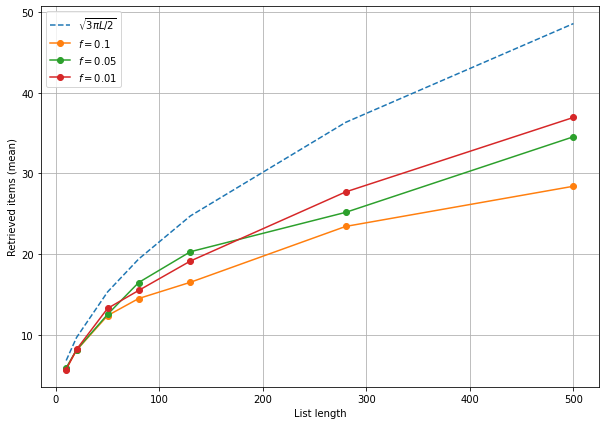

In [10]:
plt.figure(figsize=(10,7))
plt.xlabel("List length")
plt.ylabel("Retrieved items (mean)")
plt.grid()
rlist = [R_f01_mean, R_f005_mean, R_f001_mean]
plt.plot(L_val, [TheoreticalScaling(val) for val in L_val], '--', label='$\sqrt{3\pi L/2}$')
for r in range(3):
    plt.plot(L_val, rlist[r], 'o-', label='$f = '+str(f_val[r])+'$') 
plt.legend()
plt.savefig('r_vs_l.pdf', bbox_inches='tight')
plt.show()

## Download the results

In [13]:
!zip -r /content/batch.zip /content/batch

  adding: content/batch/ (stored 0%)
  adding: content/batch/R_f005_L80.pkl (deflated 62%)
  adding: content/batch/R_f001_L280.pkl (deflated 60%)
  adding: content/batch/Rf_005_20000_100runs_mean.pkl (deflated 12%)
  adding: content/batch/Rf_01_20000_100runs_mean.pkl (deflated 14%)
  adding: content/batch/R_f005_L10.pkl (deflated 73%)
  adding: content/batch/R_f005_L130.pkl (deflated 60%)
  adding: content/batch/R_f005_L500.pkl (deflated 58%)
  adding: content/batch/R_f005_L20.pkl (deflated 68%)
  adding: content/batch/Rf_001_20000_100runs_mean.pkl (deflated 13%)
  adding: content/batch/R_f001_L130.pkl (deflated 61%)
  adding: content/batch/R_f001_L50.pkl (deflated 64%)
  adding: content/batch/Rf_001_20000_100runs.pkl (deflated 50%)
  adding: content/batch/Rf_005_20000_100runs.pkl (deflated 50%)
  adding: content/batch/R_f01_L80.pkl (deflated 62%)
  adding: content/batch/R_f01_L20.pkl (deflated 67%)
  adding: content/batch/R_f001_L20.pkl (deflated 67%)
  adding: content/batch/R_f01_L28

In [14]:
from google.colab import files
files.download("/content/batch.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

---

## Backup & old code

The very first version of the `memory_recall_process` function.
```
def memory_recall_process_OLD(L, N, f):
    items = BuildItems(L, N, f)
    sim = SimilarityMatrix(items)
    # starting point: find the largest element in the first row
    recall_list = [None]*(L+1)
    recall_list[0] = np.where(sim[0, ] == sim[0, ].max())[0][0]
    for i in range(L):
        # find the largest element in a row
        recall_list[i+1] = np.where(sim[recall_list[i], ] == sim[recall_list[i], ].max())[0][0]
        # if the process points to an item that was just recalled in the previous step,
        # select the next largest overlap 
        if recall_list[i+1] == recall_list[i]:
            sl = heapq.nlargest(2, sim[recall_list[i], ])
            recall_list[i+1] = np.where(sim[recall_list[i], ] == sl[1])[0][0]
    R = len(set(recall_list))
    return R
```

Memory recall process starting from a random similarity matrix. Useless. 
```
def RandomSM_memory_recall_process(L):
    sim = np.random.rand(L, L)
    np.fill_diagonal(sim, 0)
    recall_list = [None]*(L+1)
    recall_list[0] = np.where(sim[0, ] == sim[0, ].max())[0][0]
    recall_list[1] = np.where(sim[recall_list[0], ] == sim[recall_list[0], ].max())[0][0]
    if sim[recall_list[1], recall_list[0]] == sim[recall_list[0], recall_list[1]]:
        sl = heapq.nlargest(2, sim[recall_list[0], ])
        recall_list[1] = np.where(sim[recall_list[0], ] == sl[1])[0][0]
    for i in range(1, L):
        # find the largest element in a row
        recall_list[i+1] = np.where(sim[recall_list[i], ] == sim[recall_list[i], ].max())[0][0]
        # if the process points to an item that was just recalled in the previous step,
        # select the next largest overlap 
        if sim[recall_list[i-1], recall_list[i]] == sim[recall_list[i], recall_list[i+1]]:
            sl = heapq.nlargest(2, sim[recall_list[i], ])
            recall_list[i+1] = np.where(sim[recall_list[i], ] == sl[1])[0][0]
    R = len(set(recall_list))
    return R
```

This is the old `memory_recall_process`, in which the `recall_list` array is allocated at the beginning, which for sure is not the best solution. 
```
def memory_recall_process(L, N, f):
    items = BuildItems(L, N, f)
    sim = SimilarityMatrix(items)
    print(sim)
    recall_list = [None]*(L**2)
    # always start from the first item
    recall_list[0] = 0
    # pick the most similar item to the first 
    recall_list[1] = np.where(sim[0, ] == sim[0, ].max())[0][0]
    #recall_list[2] = np.where(sim[recall_list[0], ] == sim[recall_list[0], ].max())[0][0]
    #if sim[recall_list[1], recall_list[0]] == sim[recall_list[0], recall_list[1]]:
    #    sl = heapq.nlargest(2, sim[recall_list[0], ])
    #    recall_list[1] = np.where(sim[recall_list[0], ] == sl[1])[0][0]
    for i in range(1, L):
        print("Recall list =", recall_list)
        # find the largest element in a row
        recall_list[i+1] = np.where(sim[recall_list[i], ] == sim[recall_list[i], ].max())[0][0]
        #print("i+1 before check", recall_list[i+1])
        # if the process points to an item that was just recalled in the previous step,
        # select the next largest overlap 
        #print("recall first:", recall_list[i+1])
        #print("if", recall_list[i+1], "==", recall_list[i])
        #print(sim[recall_list[i-1], recall_list[i]], "==", sim[recall_list[i], recall_list[i+1]])
        if (sim[recall_list[i-1], recall_list[i]] == sim[recall_list[i], recall_list[i+1]]):
            sl = heapq.nlargest(2, sim[recall_list[i], ])
            if sl[0] == sl[1]:
                #print("We have a problem...")
                #print("here:", np.where(sim[recall_list[i], ] == sl[1])[0][1])
                recall_list[i+1] = np.where(sim[recall_list[i], ] == sl[1])[0][1]
            else:
                recall_list[i+1] = np.where(sim[recall_list[i], ] == sl[1])[0][0]
            #print("after check:", recall_list[i+1])
    R = len(set(recall_list))
    return R
```
Memory recall v1. It does not work properly.


```
def memory_recall_process(L, N, f, vb=False):
    items = BuildItems(L, N, f)
    sim = SimilarityMatrix(items)
    if vb == True: 
        print(sim)
    recall_list = []
    recall_list.append(0)
    recall_list.append(np.where(sim[0, ] == sim[0, ].max())[0][0])
    for i in range(1, L**2): 
        #if vb == True:
        #    print("Recall list =", recall_list)
        recall_list.append(np.where(sim[recall_list[i], ] == sim[recall_list[i], ].max())[0][0])
        if (sim[recall_list[i-1], recall_list[i]] == sim[recall_list[i], recall_list[i+1]]):
            sl = heapq.nlargest(2, sim[recall_list[i], ])
            if sl[0] == sl[1]:
                recall_list[i+1] = np.where(sim[recall_list[i], ] == sl[1])[0][1]
            else:
                recall_list[i+1] = np.where(sim[recall_list[i], ] == sl[1])[0][0]
        ############################################################################################
        # INSERT A CONDITION FOR STOPPING HERE:
        # if two previously visited items are retrieved in the same order then stop.
        ############################################################################################
    R = len(set(recall_list))
    return R
```


